In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

### Reading Data

In [2]:
data= pd.read_excel('onion_data.xlsx')

In [3]:
data.head()

,Date,Arrival
0,2008-01-01,670.0
1,2008-01-02,1675.0
2,2008-01-03,600.0
3,2008-01-04,545.0
4,2008-01-05,1440.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     974 non-null    datetime64[ns]
 1   Arrival  974 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 KB


In [5]:
data.describe()

,Arrival
count,974.000000
mean,975.130493
std,278.730596
min,0.100000
25%,800.000000
50%,940.000000
75%,1123.750000
max,3040.000000


Text(0.5, 0, 'Arrival of Onions')

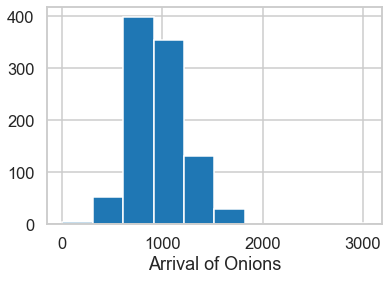

In [6]:
data['Arrival'].hist()
plt.xlabel('Arrival of Onions')

<AxesSubplot:xlabel='Arrival', ylabel='Density'>

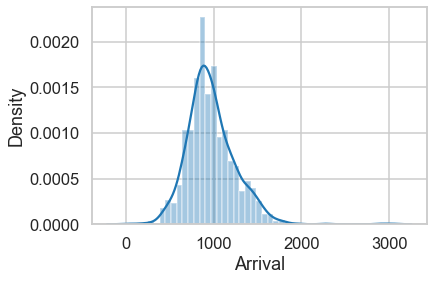

In [7]:
import seaborn as sns
sns.distplot(data['Arrival'])

From the density plot,We can say that arrival of onions is following a normal distribution


In [8]:
data=data.set_index('Date')
data.head()

,Arrival
Date,
2008-01-01,670.0
2008-01-02,1675.0
2008-01-03,600.0
2008-01-04,545.0
2008-01-05,1440.0


<AxesSubplot:xlabel='Date'>

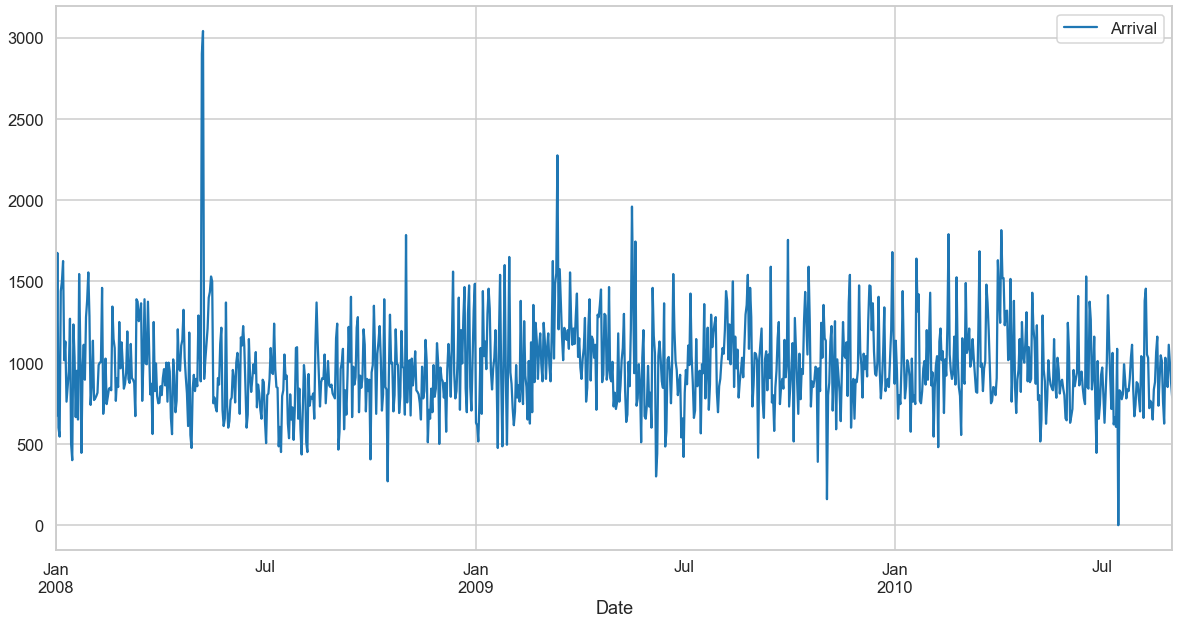

In [9]:
data.plot(figsize=(20,10))

In [10]:
split=round(len(data.Arrival)/2)
onion_data1,onion_data2=data.Arrival[0:split],data.Arrival[split:]
mean1,mean2=onion_data1.mean(),onion_data2.mean()
std1,std2=onion_data1.std(),onion_data2.std()

print('Mean1=%f , Mean2=%f' %(mean1,mean2))
print('Standard deviation1=%f , Standard deviation2=%f' %(std1,std2))

Mean1=971.207392 , Mean2=979.053593
Standard deviation1=294.573262 , Standard deviation2=262.177605


Mean and variance of the splitted data is almost same. So we can say the data is *stationery*.

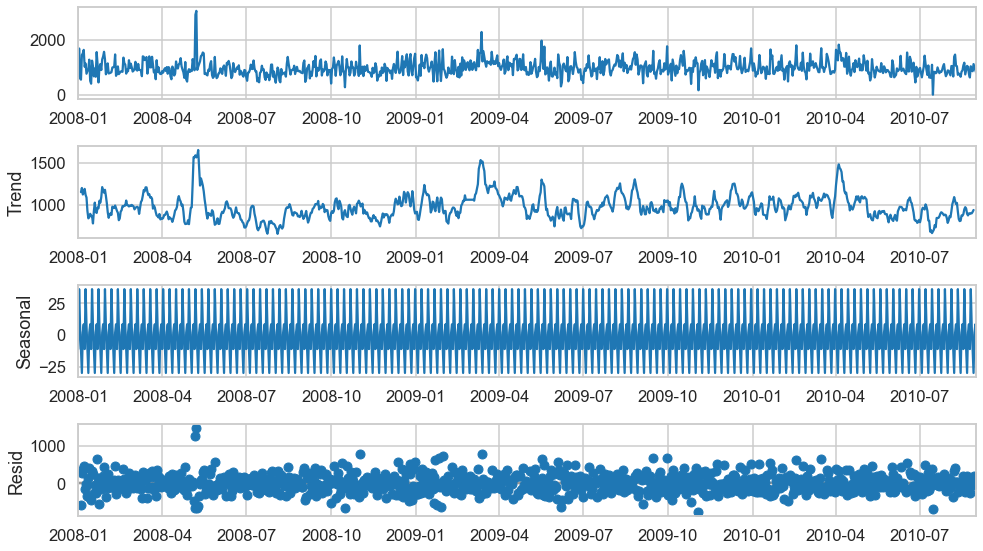

In [11]:
pylab.rcParams['figure.figsize'] = (14, 8)
ts_decomp=sm.tsa.seasonal_decompose(data,model='additive')
ts_decomp.plot()
plt.show()

In [12]:
train = data[:912] # 30 months -> 912 days!
val = data[912:943] # 1 month -> 31 days
test = data[943:] # 1 month -> 31 days

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 912 entries, 2008-01-01 to 2010-06-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  912 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


In [14]:
val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2010-07-01 to 2010-07-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2010-08-01 to 2010-08-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


<AxesSubplot:xlabel='Date'>

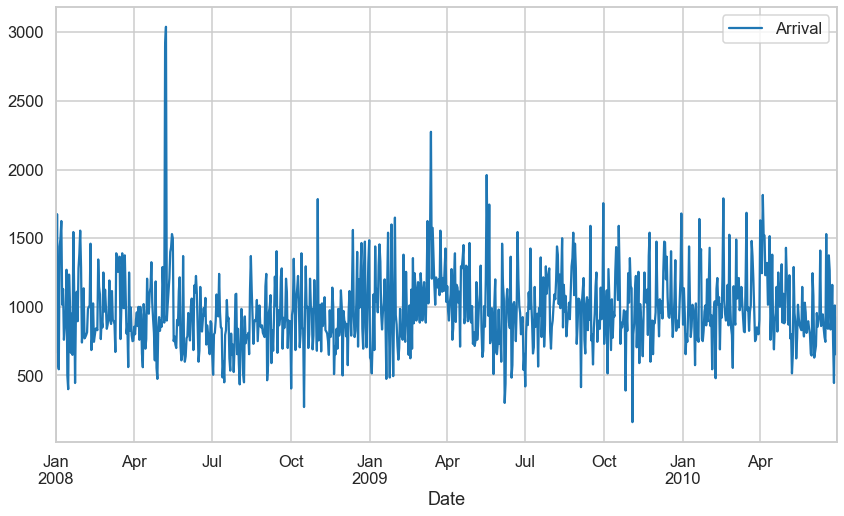

In [16]:
train.plot()

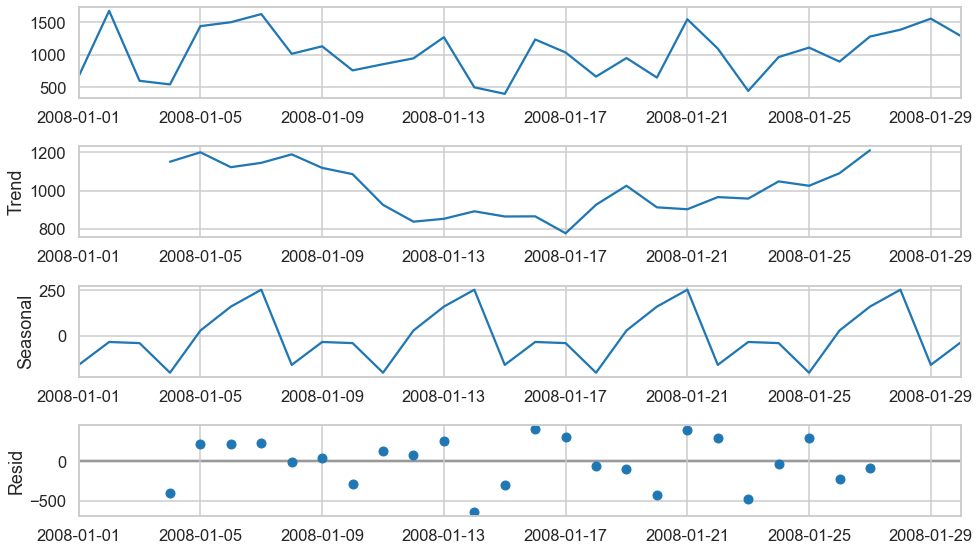

In [17]:
pylab.rcParams['figure.figsize'] = (14, 8)
ts_decomp=sm.tsa.seasonal_decompose(train[:30],model='additive')
ts_decomp.plot()
plt.show()

In [18]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.368697
p-value: 0.000000


As p=0 Dickey Fuller Test also says that data is stationery [Data is said to be stationery if p<0.05]

### Plotting ACF and PACF

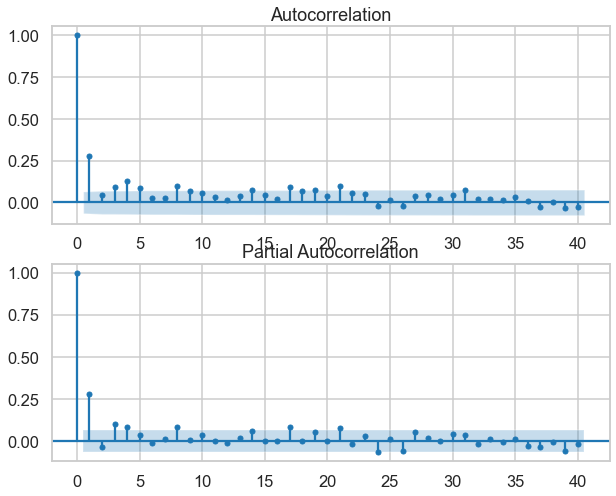

In [19]:
fig,ax =plt.subplots(2, figsize=(10,8))
ax[0] = sm.graphics.tsa.plot_acf(train['Arrival'],ax=ax[0],lags=40)
ax[1] = sm.graphics.tsa.plot_pacf(train['Arrival'],ax=ax[1],lags=40)

In [20]:
train['seasonal_order_diff'] = train['Arrival']-train['Arrival'].shift(7)
train.head()

,Arrival,seasonal_order_diff
Date,,
2008-01-01,670.0,NaN
2008-01-02,1675.0,NaN
2008-01-03,600.0,NaN
2008-01-04,545.0,NaN
2008-01-05,1440.0,NaN


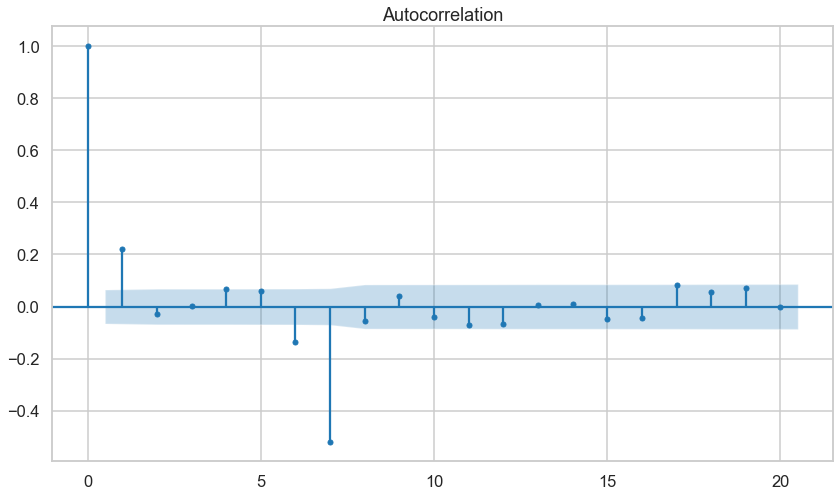

<Figure size 1080x504 with 0 Axes>

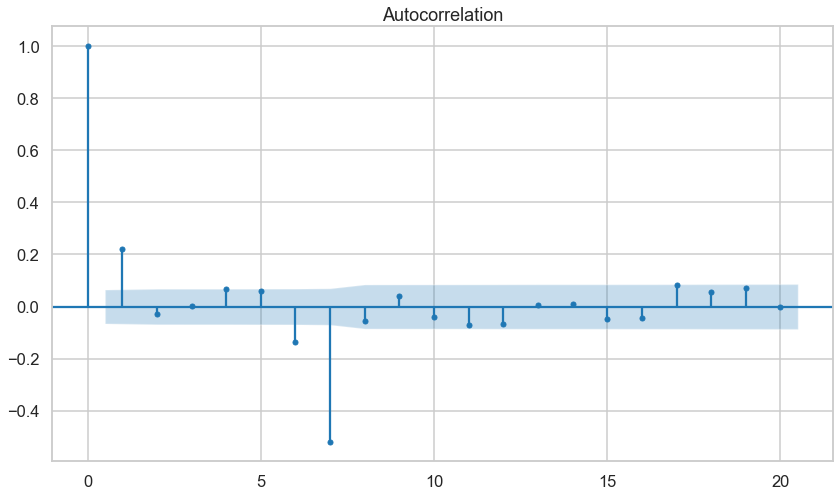

In [21]:
plt.figure(figsize=(15,7))
sm.graphics.tsa.plot_acf(train['seasonal_order_diff'].dropna(),lags=20)

- ARIMA(1,0,1) X (1,1,2)7
- ARIMA(1,0,0) X (1,1,0)7
- ARIMA(1,0,1) X (1,1,0)7
- ARIMA(1,0,1) X (1,1,1)7

In [22]:
model1 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 2, 7))
model_aic1 = model1.fit()
print(model_aic1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.111      0.661      0.509      -0.144       0.290
ma.L1          0.2237      0.112      1.999      0.046       0.004       0.443
ar.S.L7       -0.8519      5.771     -0.148      0.883     -12.163      10.459
ma.S.L7       -0.1472      5.979     -0.025      0.980     -11.865      11.571
ma.S.L14      -0.8526      5.896     -0.145      0.885     -12.408      10.703
sigma2      7.361e+04   1.15e+05      0.643      0.520   -1.51e+05    2.98e+05


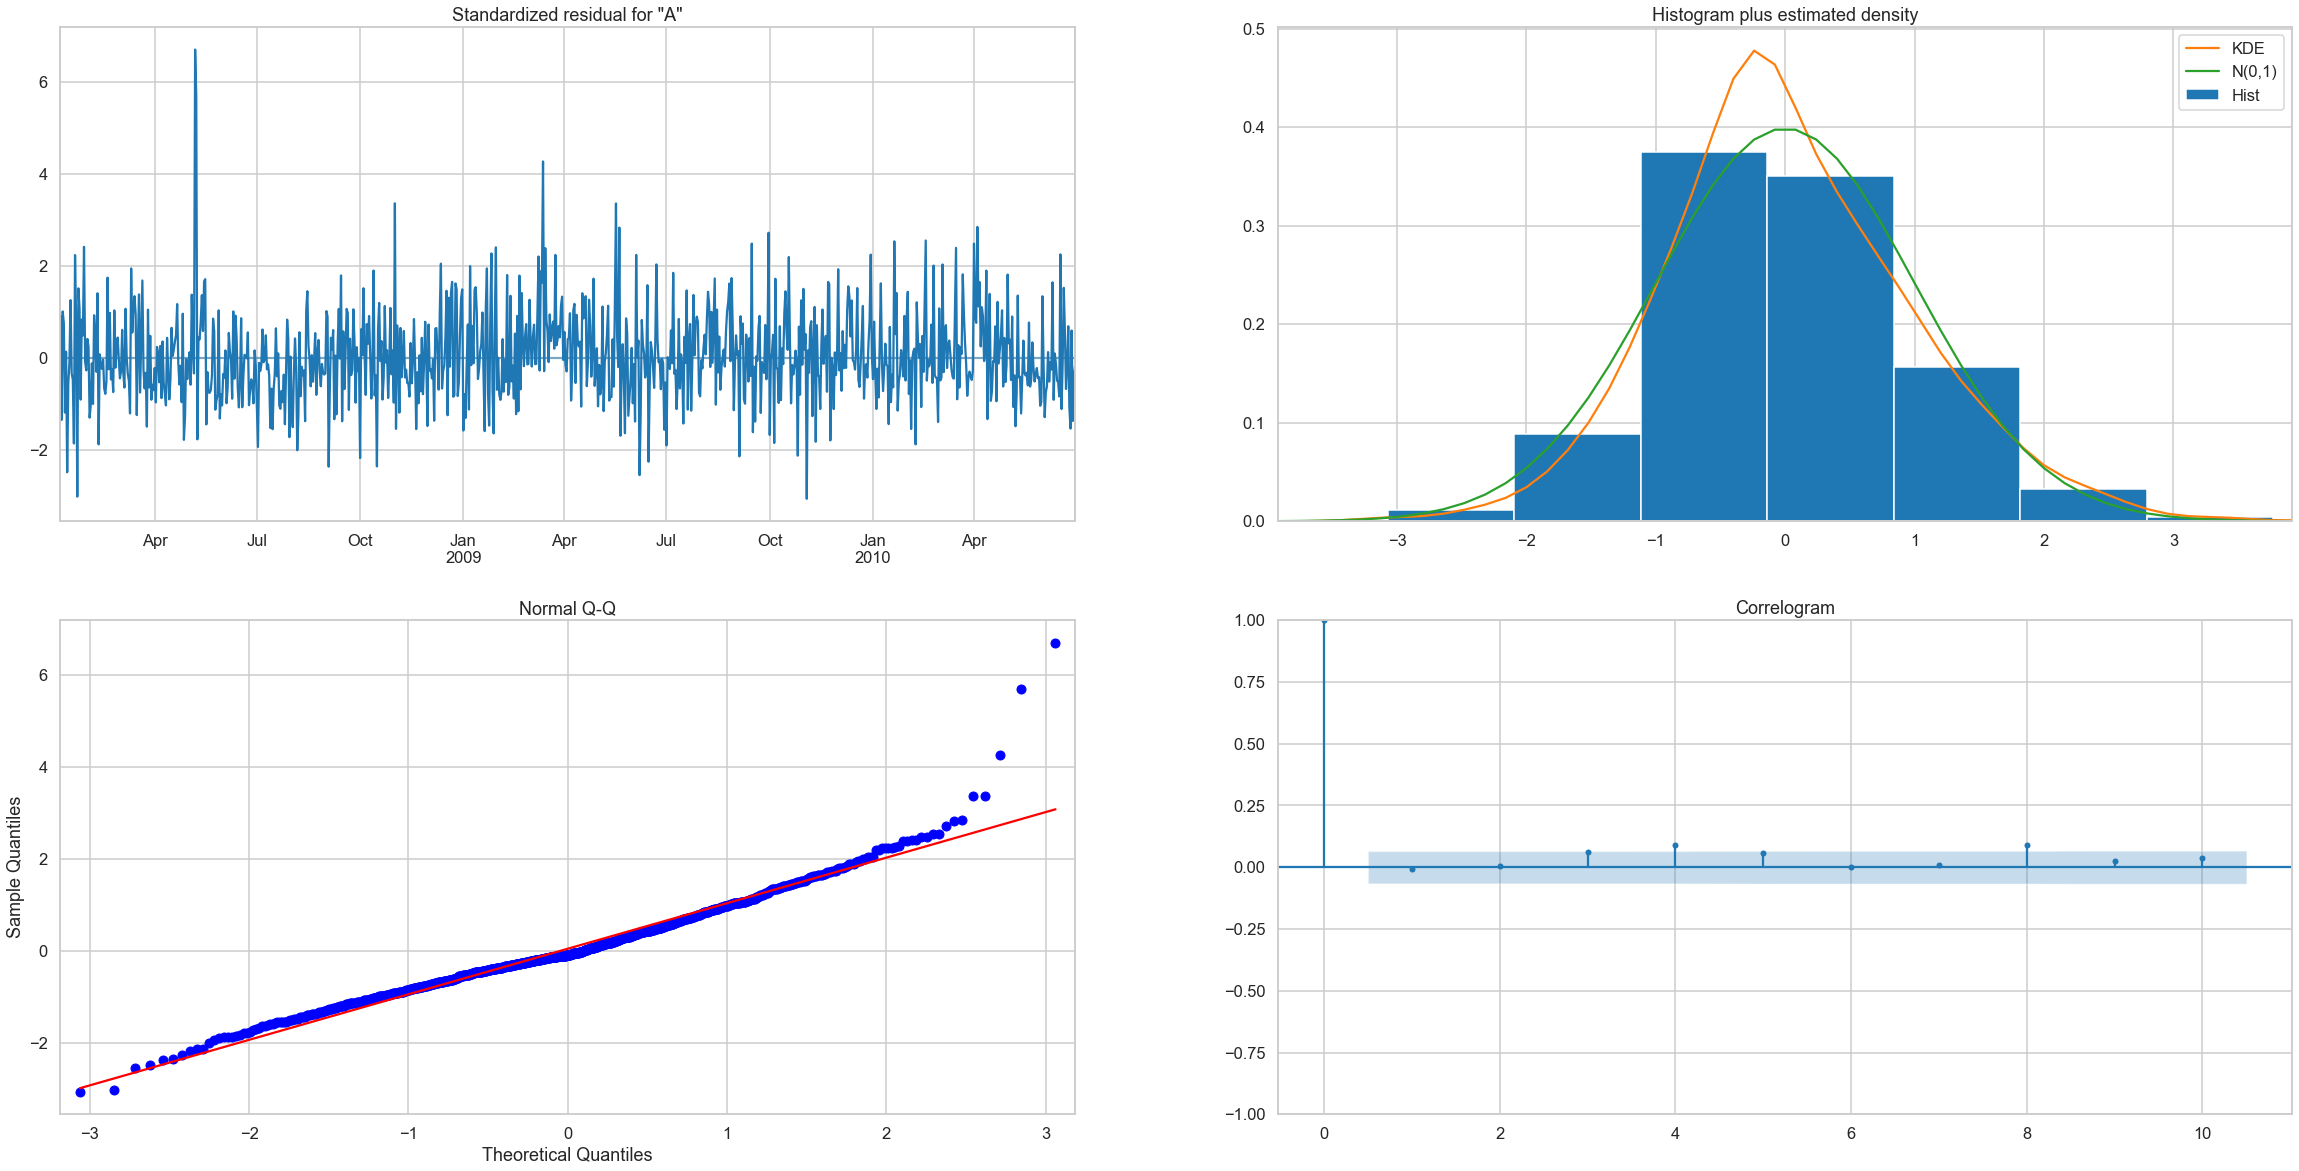

In [23]:
model_aic1.plot_diagnostics(figsize=(40,20))
plt.show()

<AxesSubplot:xlabel='Date'>

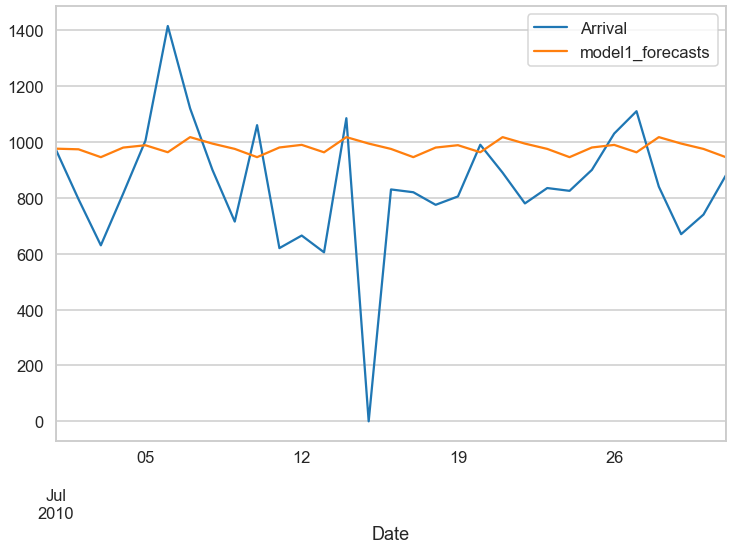

In [24]:
data['model1_forecasts'] = model_aic1.predict(start=912, end=974, dynamic=True)
data[912:943][['Arrival','model1_forecasts']].plot(figsize=(12,8))

In [25]:
model2 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 0),seasonal_order=(1, 1, 0, 7))
model_aic2 = model2.fit() 
print(model_aic2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2525      0.022     11.260      0.000       0.209       0.296
ar.S.L7       -0.5375      0.024    -22.208      0.000      -0.585      -0.490
sigma2      1.033e+05   3306.158     31.248      0.000    9.68e+04     1.1e+05


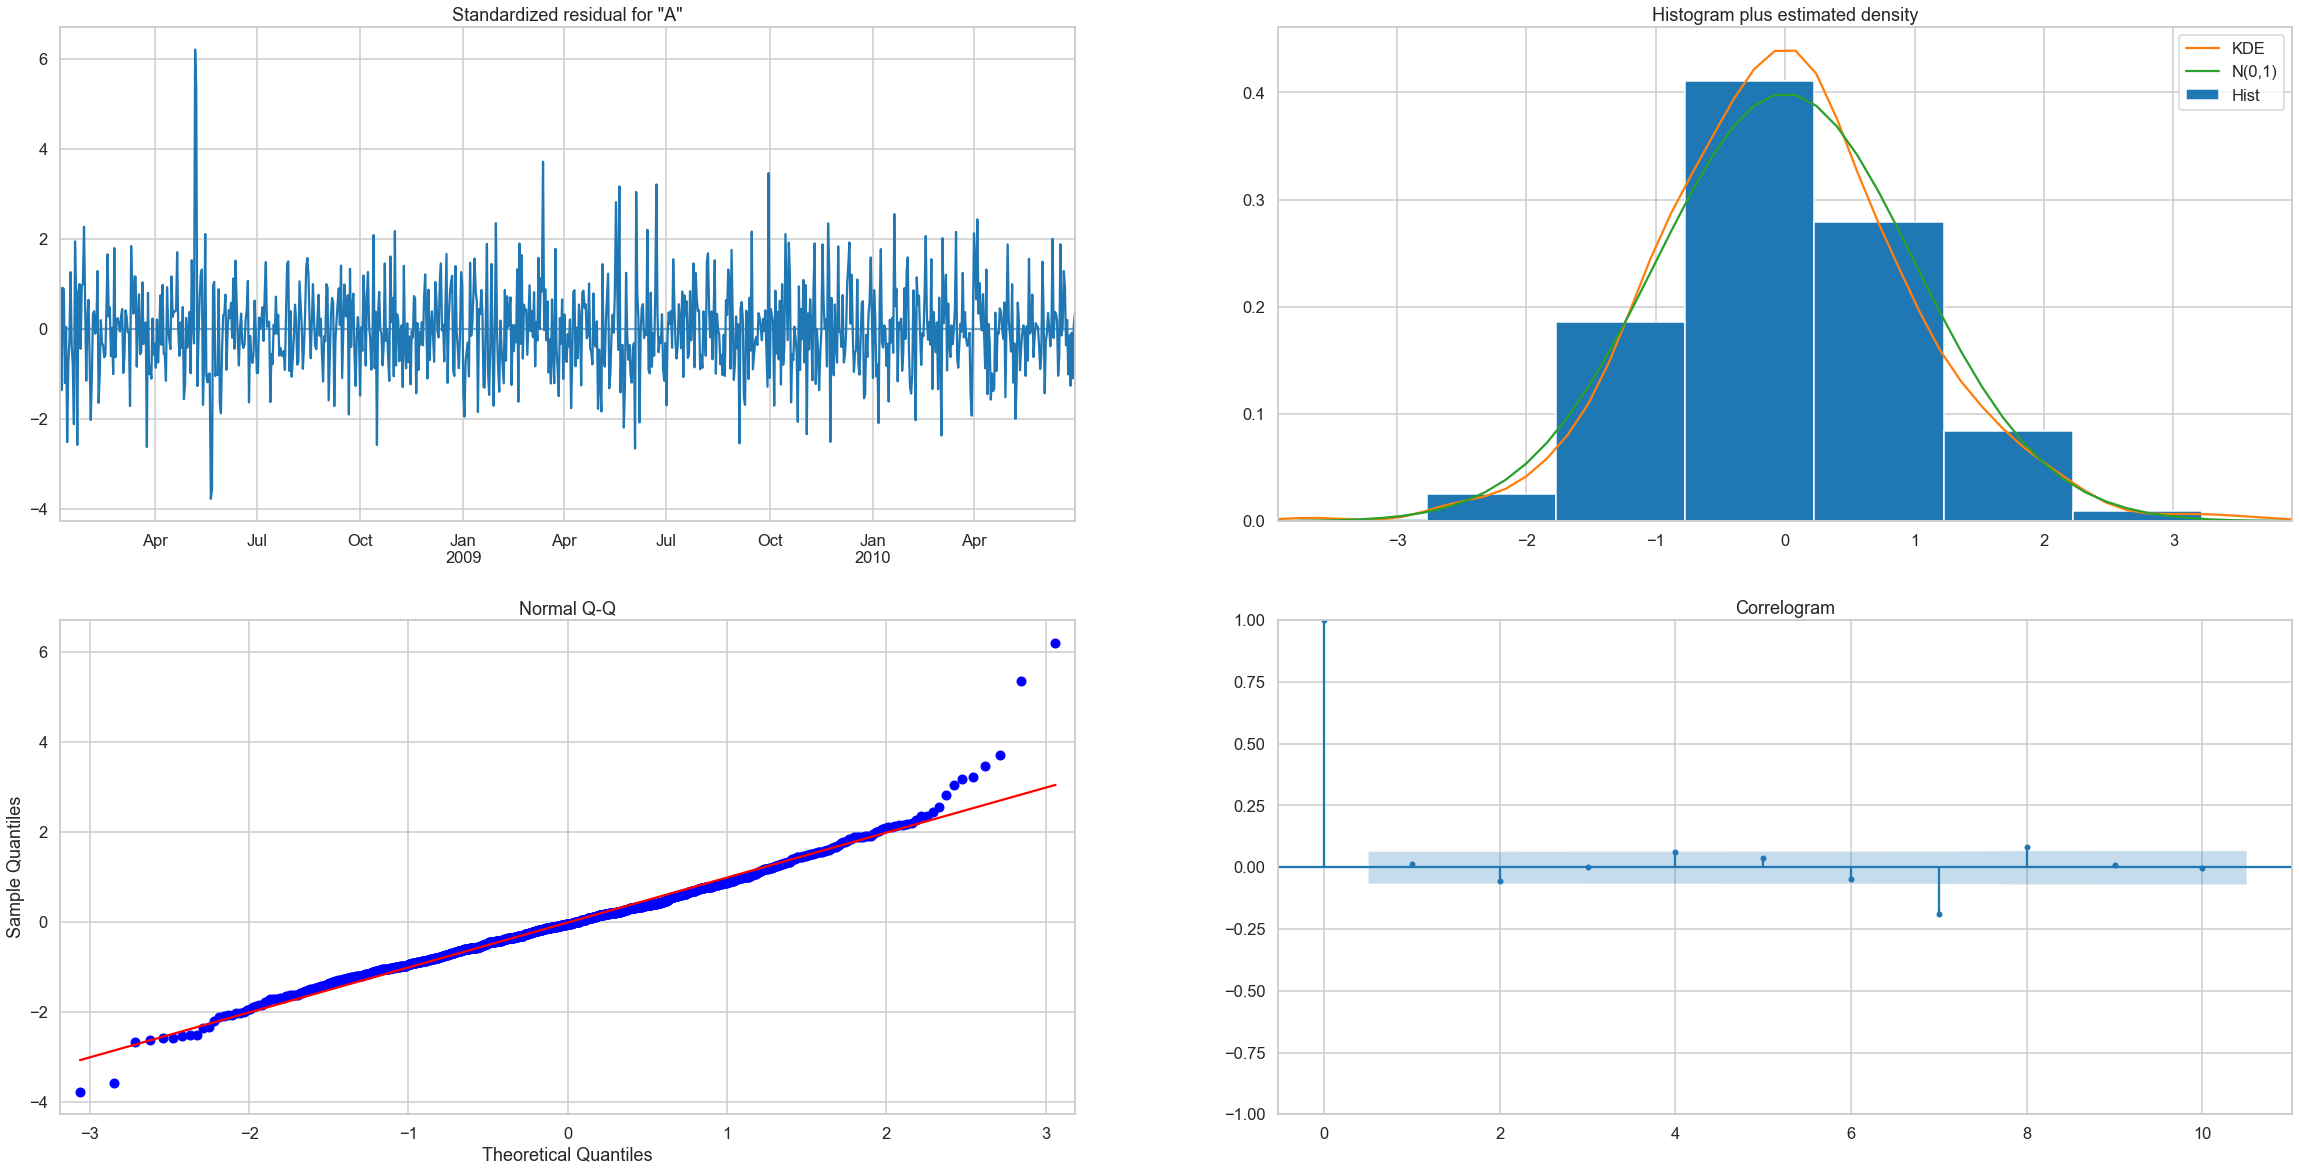

In [26]:
model_aic2.plot_diagnostics(figsize=(40,20))
plt.show()

<AxesSubplot:xlabel='Date'>

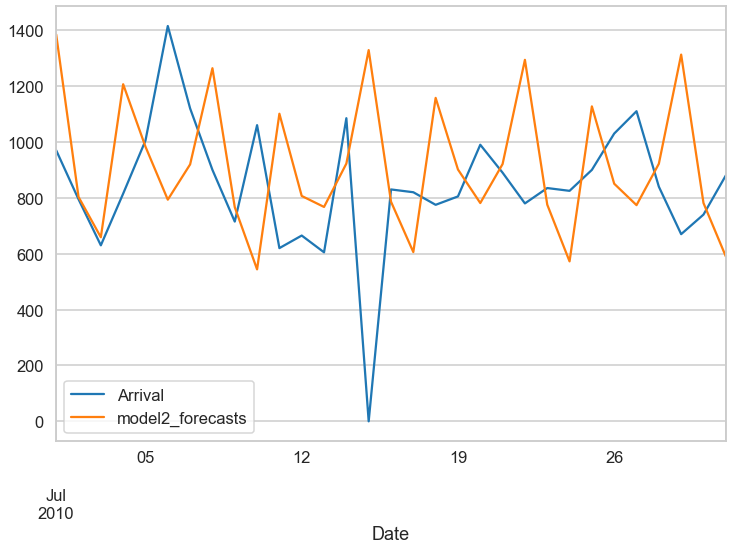

In [27]:
data['model2_forecasts'] = model_aic2.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model2_forecasts']].plot(figsize=(12,8))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0539      0.135      0.399      0.690      -0.211       0.319
ma.L1          0.2129      0.136      1.570      0.116      -0.053       0.479
ar.S.L7       -0.5354      0.024    -21.979      0.000      -0.583      -0.488
sigma2       1.03e+05   3292.050     31.288      0.000    9.65e+04    1.09e+05


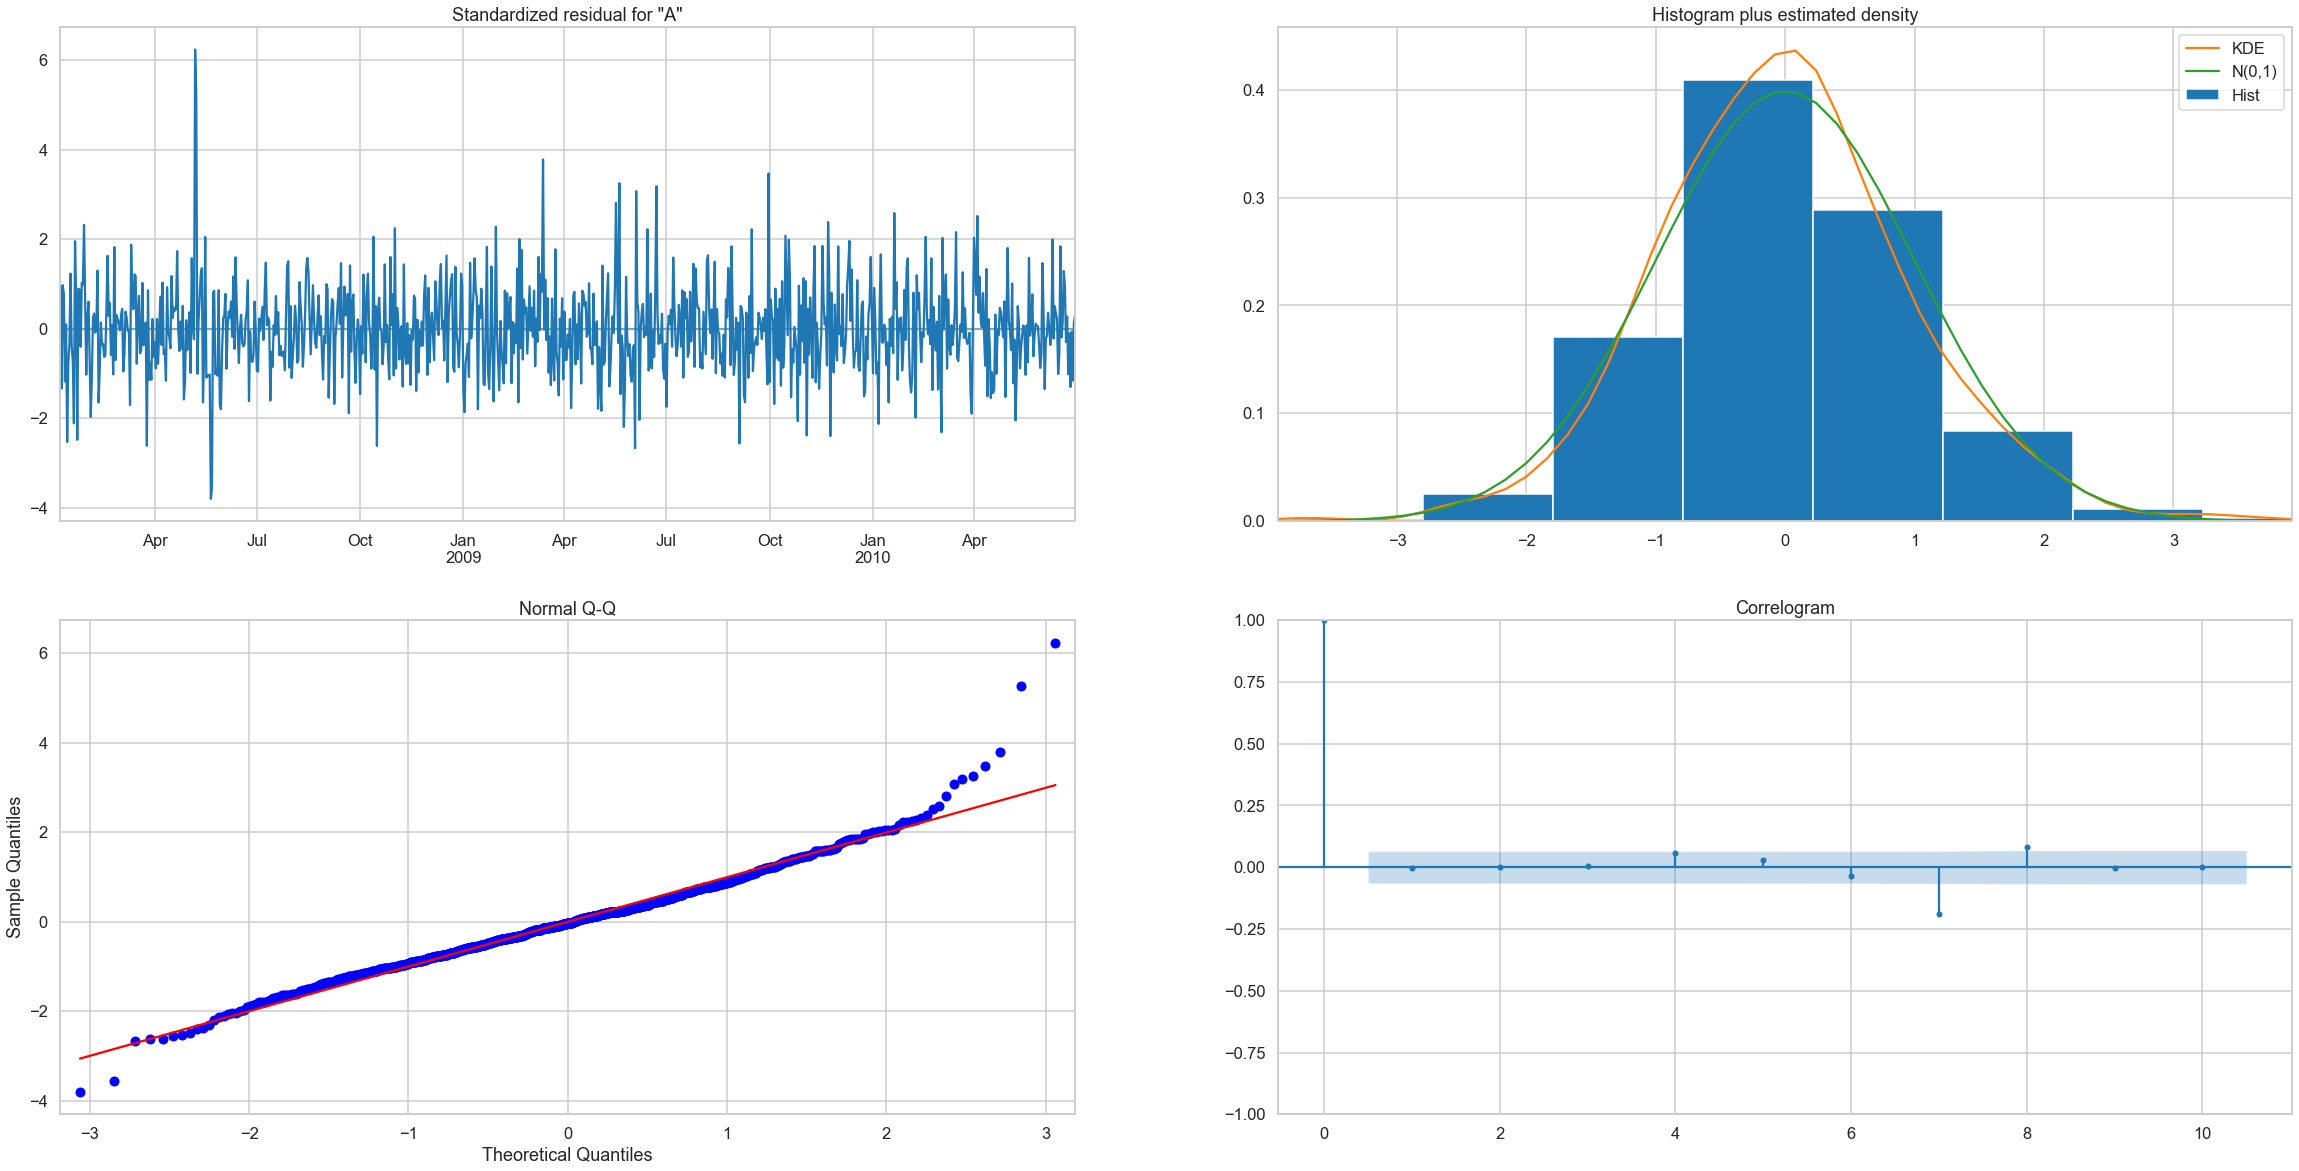

<AxesSubplot:xlabel='Date'>

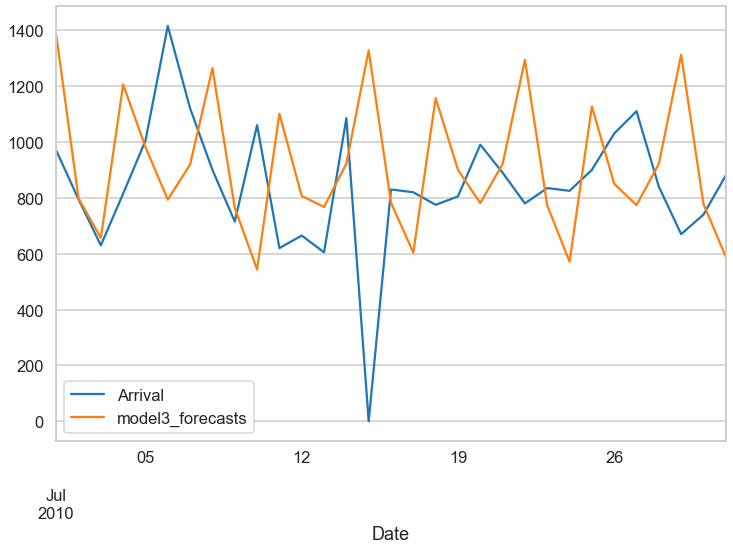

In [28]:
model3 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 0, 7))
model_aic3 = model3.fit() 
print(model_aic3.summary().tables[1])

model_aic3.plot_diagnostics(figsize=(40,20))
plt.show()

data['model3_forecasts'] = model_aic3.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model3_forecasts']].plot(figsize=(12,8))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0696      0.109      0.641      0.522      -0.143       0.282
ma.L1          0.2267      0.109      2.083      0.037       0.013       0.440
ar.S.L7       -0.0019      0.036     -0.055      0.956      -0.072       0.068
ma.S.L7       -0.9999      1.495     -0.669      0.504      -3.930       1.930
sigma2      7.272e+04   1.08e+05      0.672      0.502   -1.39e+05    2.85e+05


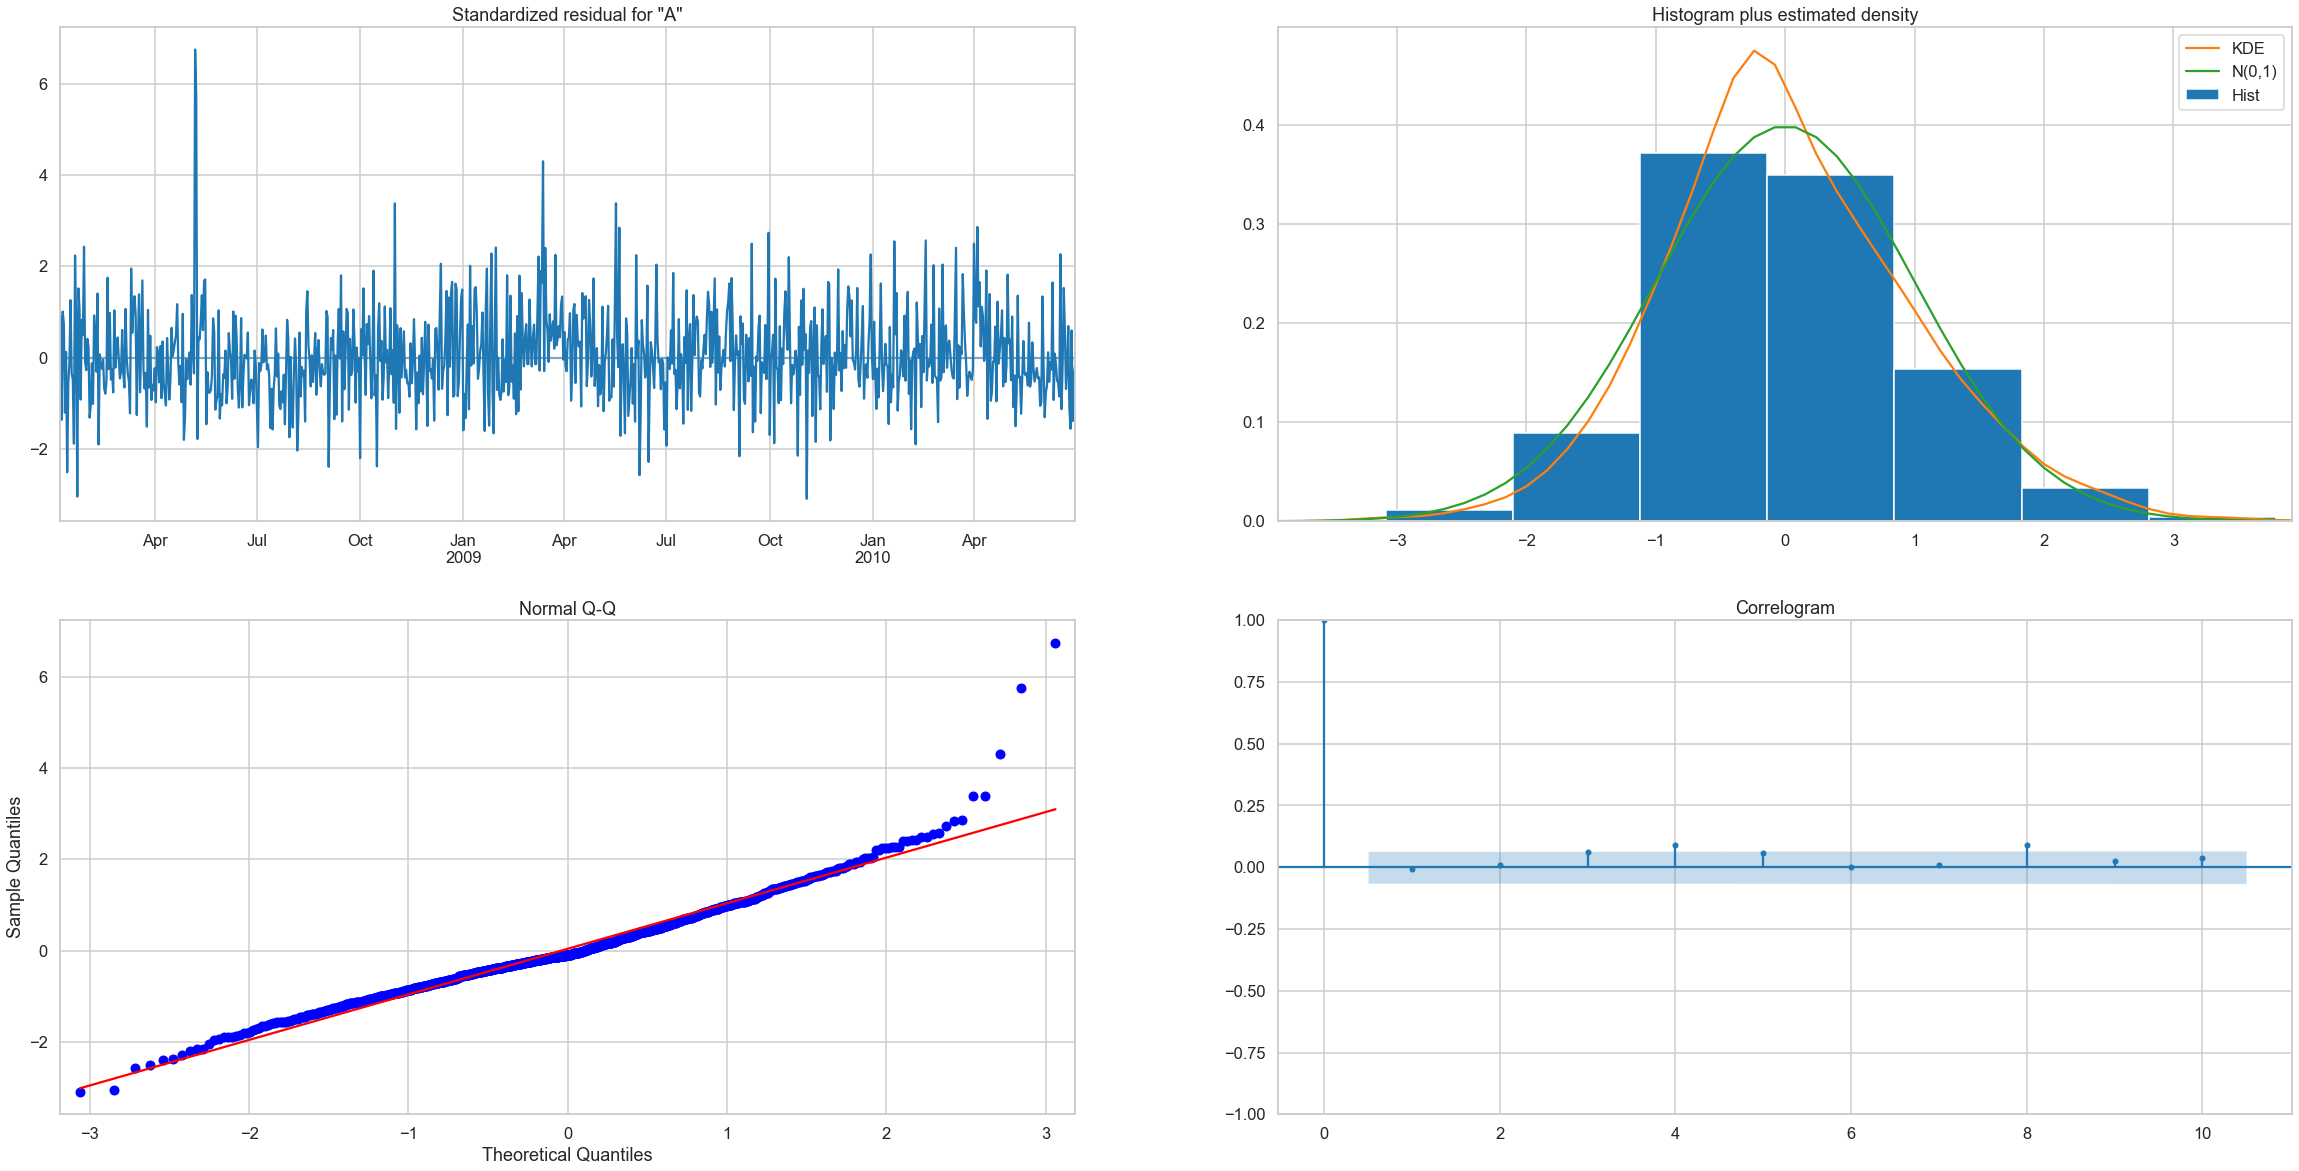

<AxesSubplot:xlabel='Date'>

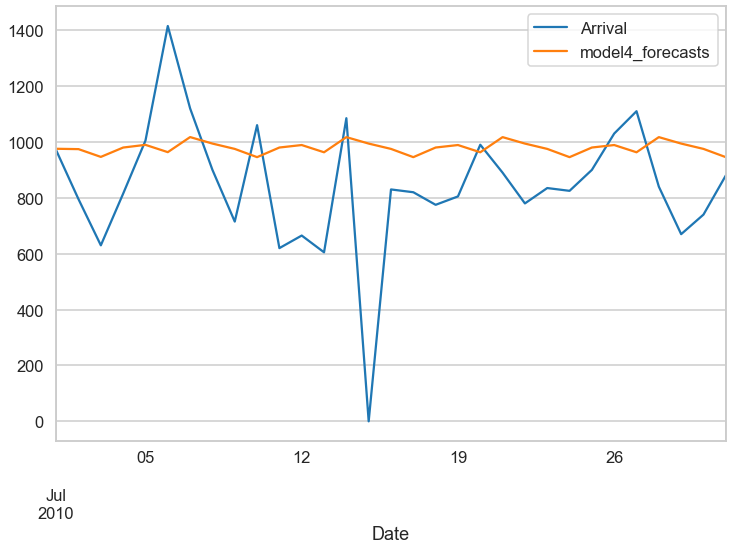

In [29]:
model4 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 1, 7))
model_aic4 = model4.fit() 
print(model_aic4.summary().tables[1])

model_aic4.plot_diagnostics(figsize=(40,20))
plt.show()

data['model4_forecasts'] = model_aic4.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model4_forecasts']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

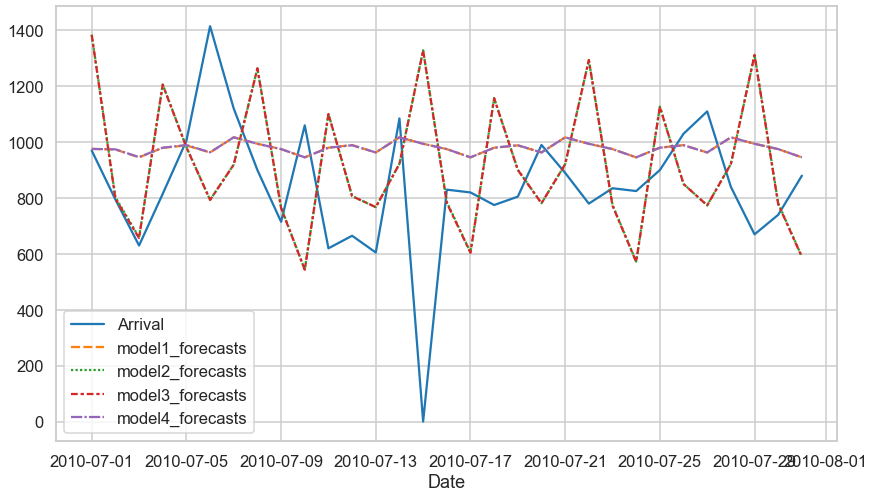

In [30]:
sns.lineplot(data=data[912:943])

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [32]:
print('MAPE for ARIMA(1,0,1)X(1,1,2)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model1_forecasts'])))
print('MAPE for ARIMA(1,0,0)X(1,1,0)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model2_forecasts'])))
print('MAPE for ARIMA(1,0,1)X(1,1,0)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model3_forecasts'])))
print('MAPE for ARIMA(1,0,1)X(1,1,1)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model4_forecasts'])))

MAPE for ARIMA(1,0,1)X(1,1,2)7: 32089.220029456315
MAPE for ARIMA(1,0,0)X(1,1,0)7: 42883.93565029209
MAPE for ARIMA(1,0,1)X(1,1,0)7: 42869.952708685385
MAPE for ARIMA(1,0,1)X(1,1,1)7: 32087.259595335352


### Validation forecasts

<AxesSubplot:xlabel='Date'>

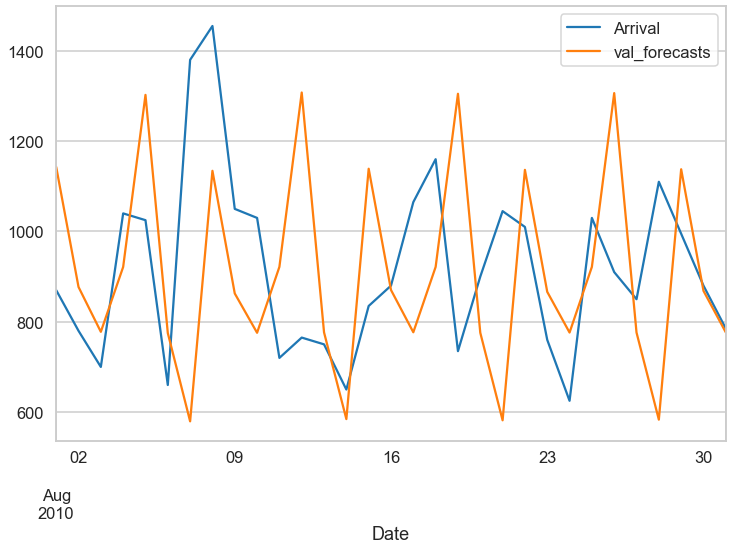

In [33]:
data['val_forecasts'] = model_aic3.predict(start=943, end=974, dynamic=True)
data[943:974][['Arrival','val_forecasts']].plot(figsize=(12,8))